In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

import sklearn

%matplotlib inline
from nsepy import get_history
from datetime import date

from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error
from sklearn.metrics import mean_squared_error,mean_squared_log_error

In [3]:
tcs_data = get_history(symbol="TCS", start=date(2015,1,1), end=date(2016,12,31))
infy_data = get_history(symbol="INFY", start=date(2015,1,1), end=date(2016,12,31))
nifty_it = get_history(symbol="NIFTY IT", start=date(2015,1,1), end=date(2017,12,31), index=True)

In [13]:
tcs_data.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2015-01-01,TCS,EQ,2558.25,2567.0,2567.00,2541.00,2550.00,2545.55,2548.51,183415,4.674345e+13,8002,52870,0.2883
2015-01-02,TCS,EQ,2545.55,2551.0,2590.95,2550.60,2588.40,2579.45,2568.19,462870,1.188740e+14,27585,309350,0.6683
2015-01-05,TCS,EQ,2579.45,2581.0,2599.90,2524.65,2538.10,2540.25,2563.94,877121,2.248886e+14,43234,456728,0.5207
2015-01-06,TCS,EQ,2540.25,2529.1,2529.10,2440.00,2450.05,2446.60,2466.90,1211892,2.989615e+14,84503,714306,0.5894
2015-01-07,TCS,EQ,2446.60,2470.0,2479.15,2407.45,2426.90,2417.70,2433.96,1318166,3.208362e+14,101741,886368,0.6724


In [14]:
infy_data.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2015-01-01,INFY,EQ,1972.55,1968.95,1982.00,1956.9,1971.00,1974.40,1971.34,500691,9.870306e+13,14908,258080,0.5154
2015-01-02,INFY,EQ,1974.40,1972.00,2019.05,1972.0,2017.95,2013.20,2003.25,1694580,3.394669e+14,54166,1249104,0.7371
2015-01-05,INFY,EQ,2013.20,2009.90,2030.00,1977.5,1996.00,1995.90,2004.59,2484256,4.979911e+14,82694,1830962,0.7370
2015-01-06,INFY,EQ,1995.90,1980.00,1985.00,1934.1,1965.10,1954.20,1954.82,2416829,4.724458e+14,108209,1772070,0.7332
2015-01-07,INFY,EQ,1954.20,1965.00,1974.75,1950.0,1966.05,1963.55,1962.59,1812479,3.557162e+14,62463,1317720,0.7270


In [119]:
nifty_it.tail()

,Open,High,Low,Close,Volume,Turnover
Date,,,,,,
2017-12-22,11368.2,11532.75,11345.25,11501.90,18433681.0,1.574070e+10
2017-12-26,11503.0,11531.25,11454.90,11507.40,17496410.0,1.224740e+10
2017-12-27,11490.3,11538.70,11465.60,11509.25,13758340.0,8.253000e+09
2017-12-28,11481.8,11549.80,11460.80,11496.40,33607636.0,1.547850e+10
2017-12-29,11479.5,11689.75,11430.65,11665.75,123646100.0,2.644270e+10


# **PART 1**

# Question 1

In [4]:
def plotMovingAverage(series, window, scale = 1.96):
    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window = window).mean()
       
    plt.figure(figsize = (15, 10))
    plt.title('Moving Average \n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label = 'Rolling Mean Trend')
    
    
    plt.plot(series[window:], label = 'Actual Values')
    plt.legend(loc = 'upper left')

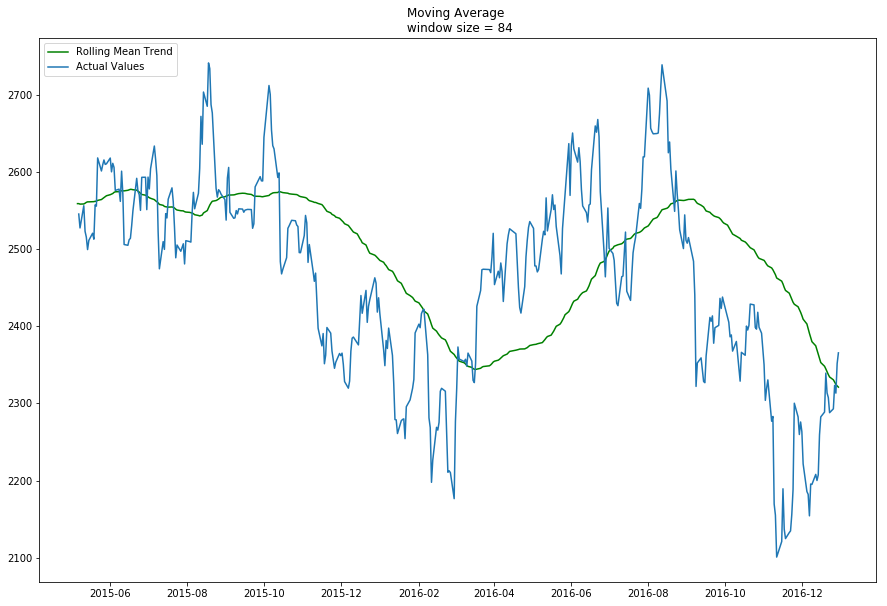

In [5]:
plotMovingAverage(tcs_data['Close'], 84)

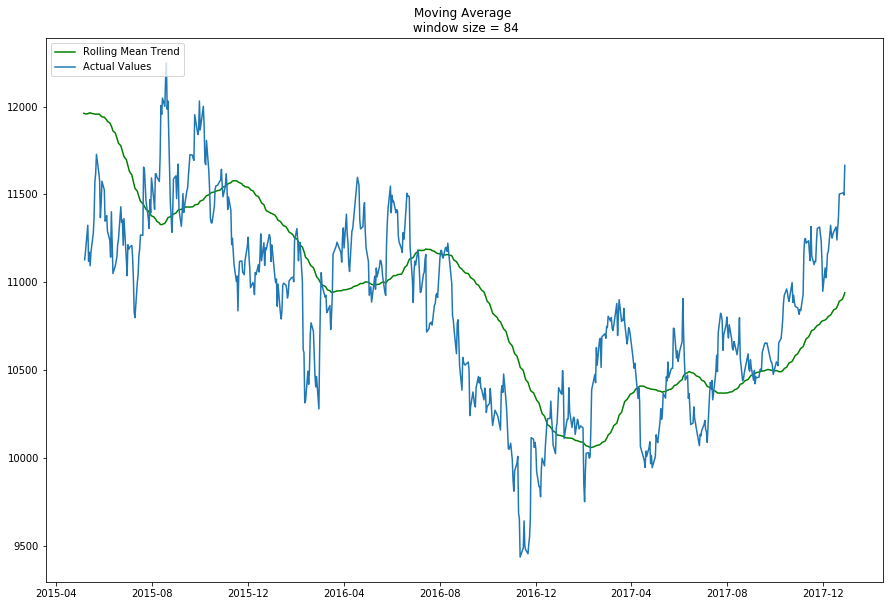

In [6]:
plotMovingAverage(nifty_it['Close'], 84)

# Question 2

Adding the missing dates in a temporary database for TCS, INFY and NIFTY_IT

In [7]:
idx = pd.date_range('2015-01-01', '2016-12-31')

demo_tcs = tcs_data.copy(deep = False)
demo_tcs.index = pd.DatetimeIndex(demo_tcs.index)
demo_tcs = demo_tcs.reindex(idx, fill_value=0)

demo_infy = infy_data.copy(deep = False)
demo_infy.index = pd.DatetimeIndex(demo_infy.index)
demo_infy = demo_infy.reindex(idx, fill_value=0)

demo_nifty_it = nifty_it.copy(deep = False)
demo_nifty_it.index = pd.DatetimeIndex(demo_nifty_it.index)
demo_nifty_it = demo_nifty_it.reindex(idx, fill_value=0)

In [8]:
demo_tcs.drop(labels = ['Symbol', 'Series'], axis = 1, inplace = True)
rolling_mean_tcs = demo_tcs.rolling(window = 10).mean()

demo_infy.drop(labels = ['Symbol', 'Series'], axis = 1, inplace = True)
rolling_mean_infy = demo_infy.rolling(window = 10).mean()

rolling_mean_nifty_it = demo_nifty_it.rolling(window = 10).mean()

In [9]:
rolling_mean_tcs[10:].head(n  = 20)

,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
2015-01-11,1497.335,1502.850,1516.800,1479.325,1495.945,1494.010,1495.781,625157.4,1.552243e+14,38650.5,368329.7,0.35682
2015-01-12,1494.010,1499.450,1510.505,1472.290,1489.900,1487.035,1488.744,658670.7,1.632695e+14,41773.0,382517.5,0.34653
2015-01-13,1744.980,1751.450,1763.545,1720.300,1739.700,1736.825,1739.684,732092.3,1.816939e+14,46772.3,421130.8,0.39912
2015-01-14,1994.770,2003.050,2016.725,1970.350,1992.205,1989.020,1991.438,821447.1,2.041894e+14,53696.0,470950.1,0.45487
2015-01-15,1989.020,1998.250,2014.910,1970.210,1992.600,1988.905,1990.141,984231.0,2.456013e+14,59008.9,585161.9,0.46663
2015-01-16,1988.905,1999.710,2016.500,1974.640,2000.195,1997.460,1994.590,1127733.3,2.821796e+14,63343.3,650951.3,0.45953
2015-01-17,1744.245,1752.710,1768.585,1733.895,1757.505,1755.690,1751.194,995916.7,2.500959e+14,53169.2,562314.5,0.39229
2015-01-18,1502.475,1508.470,1523.685,1491.840,1512.905,1511.310,1507.713,917646.3,2.310386e+14,48399.3,517237.7,0.33470
2015-01-19,1511.310,1516.570,1526.795,1497.140,1512.805,1511.180,1510.318,814517.9,2.055073e+14,44111.0,461575.6,0.33502
2015-01-20,1762.410,1768.570,1779.795,1745.465,1762.605,1761.225,1760.212,917446.2,2.312285e+14,49917.6,534924.3,0.40628


In [10]:
rolling_mean_infy[10:].head(n = 20)

,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
2015-01-11,1187.470,1189.26,1211.480,1169.665,1199.965,1197.475,1193.572,2301520.6,4.620075e+14,75949.8,1222535.7,0.40267
2015-01-12,1197.475,1201.26,1221.495,1179.965,1209.465,1207.750,1203.187,2451034.8,4.950260e+14,81254.1,1279505.3,0.38598
2015-01-13,1409.070,1412.04,1432.275,1387.465,1418.665,1416.640,1412.129,2671065.7,5.409997e+14,87921.7,1418006.2,0.44893
2015-01-14,1617.960,1621.89,1645.575,1596.725,1631.565,1629.505,1623.217,2919097.2,5.933561e+14,93248.0,1601302.0,0.52283
2015-01-15,1629.505,1634.42,1657.855,1610.200,1644.965,1643.340,1636.504,2879232.9,5.881361e+14,89866.8,1559305.0,0.51678
2015-01-16,1643.340,1651.22,1675.355,1627.990,1659.955,1659.750,1653.599,2804824.0,5.764501e+14,85430.7,1507498.4,0.51843
2015-01-17,1447.920,1454.72,1477.880,1432.990,1463.350,1463.395,1457.340,2623576.1,5.408785e+14,79184.4,1375726.4,0.44573
2015-01-18,1251.565,1256.16,1278.180,1237.990,1265.425,1266.050,1260.062,2284453.1,4.739769e+14,69909.2,1107125.2,0.36653
2015-01-19,1266.050,1270.15,1280.515,1256.145,1268.395,1268.855,1266.748,1265063.5,2.669401e+14,40284.1,837571.1,0.40244
2015-01-20,1476.300,1480.85,1493.815,1466.290,1480.315,1481.275,1478.564,1435176.1,3.029727e+14,46971.2,965984.8,0.47793


In [11]:
rolling_mean_nifty_it[10:].head(n = 20)

,Open,High,Low,Close,Volume,Turnover
2015-01-11,6687.250,6760.435,6604.740,6691.435,8014231.6,9.613550e+09
2015-01-12,6711.385,6777.110,6621.155,6708.590,8664252.8,1.036130e+10
2015-01-13,7865.910,7931.770,7764.950,7858.870,9915388.6,1.177881e+10
2015-01-14,9022.105,9094.925,8917.050,9020.300,11169844.4,1.321734e+10
2015-01-15,9052.400,9129.000,8955.865,9062.430,11672263.9,1.392290e+10
2015-01-16,9104.675,9181.275,9023.250,9132.400,11657500.7,1.427309e+10
2015-01-17,8003.355,8077.040,7934.295,8040.800,10559865.1,1.306965e+10
2015-01-18,6900.240,6971.225,6842.790,6938.985,9262353.4,1.158402e+10
2015-01-19,6967.685,7002.495,6912.475,6963.295,8150769.1,9.231350e+09
2015-01-20,8135.865,8174.685,8076.045,8132.795,9252910.6,1.046608e+10


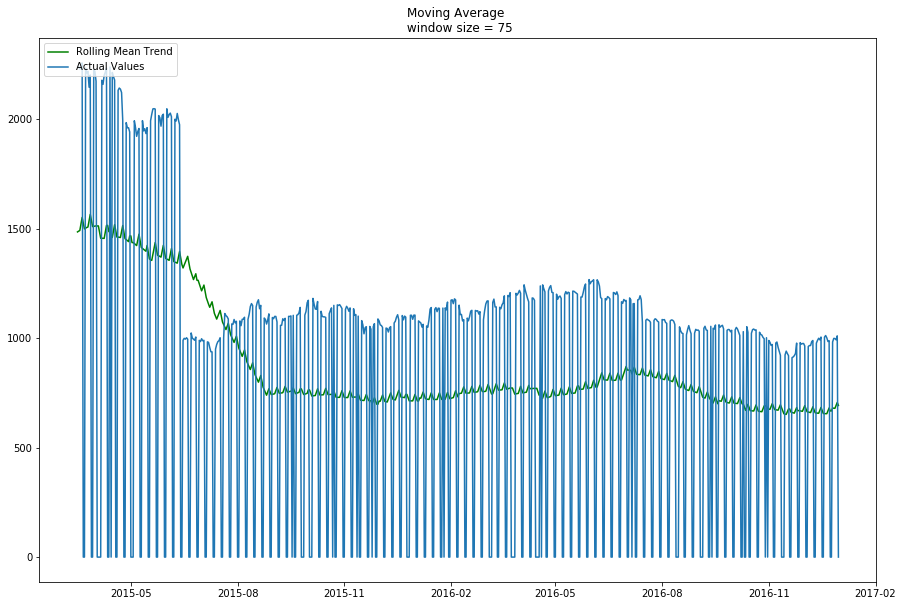

In [12]:
plotMovingAverage(demo_infy['Close'], window = 75)

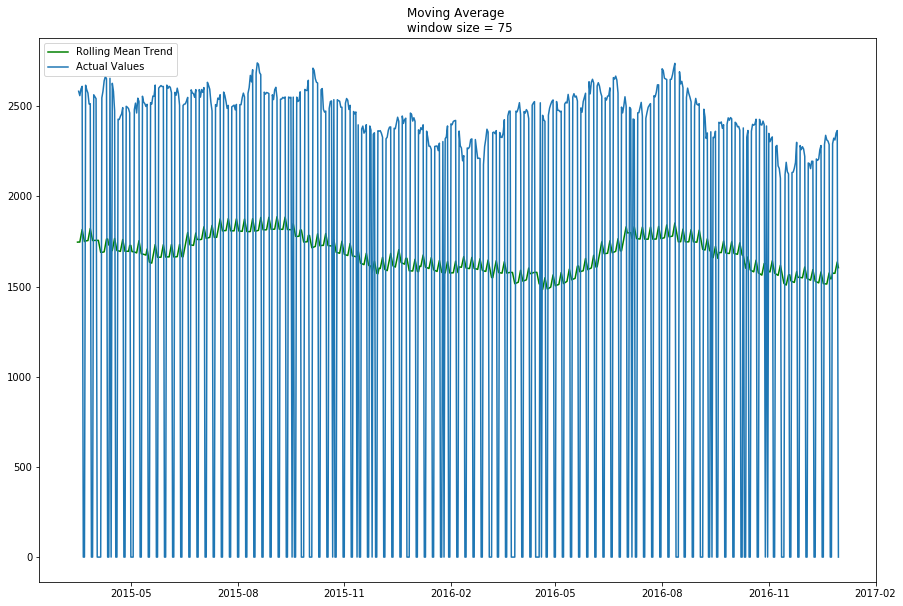

In [13]:
plotMovingAverage(demo_tcs['Close'], window = 75)

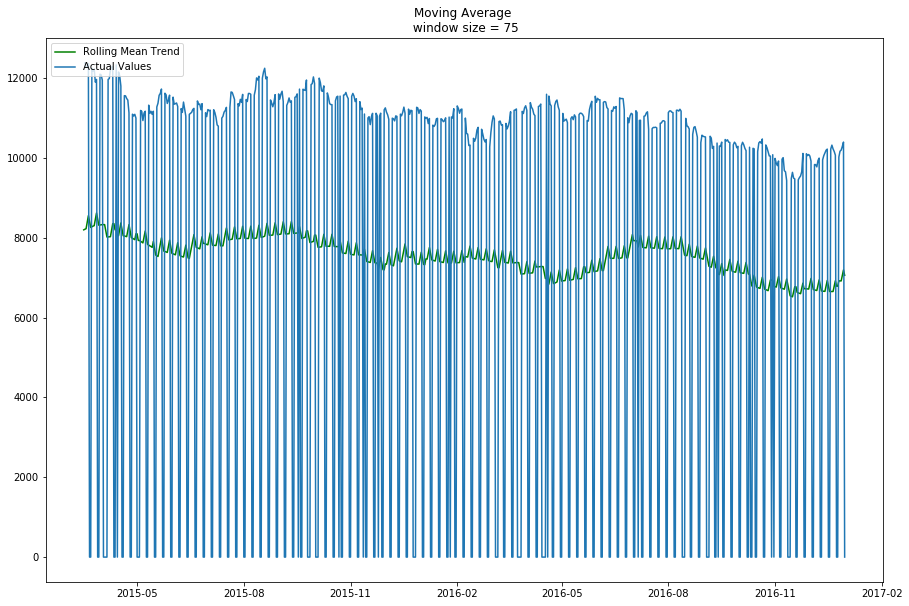

In [14]:
plotMovingAverage(demo_nifty_it['Close'], window = 75)

# Question 3

**Question 3.a**

0/1 boolean time series for shock

In [78]:
temp_tcs = pd.Series(index = tcs_data.index)
bool_tcs = pd.Series(index = tcs_data.index)

In [79]:
for i in range(len(tcs_data) - 1):
    temp_tcs[i+1] = ((tcs_data['Volume'][i+1] - tcs_data['Volume'][i])/tcs_data['Volume'][i])*100

In [80]:
bool_tcs.loc[temp_tcs.loc[(temp_tcs >= 10) | (temp_tcs <= -10)].index.values] = 1
bool_tcs.loc[temp_tcs.loc[(temp_tcs < 10) & (temp_tcs > -10)].index.values] = 0

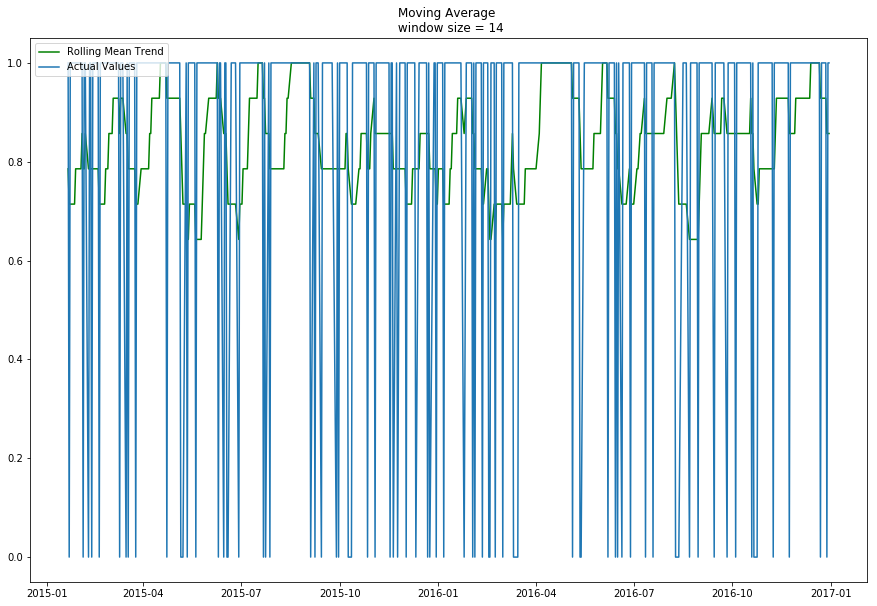

In [83]:
plotMovingAverage(bool_tcs, window = 14)

**Question 3.b**

0/1 boolean time series for shock

In [95]:
temp_tcs = pd.Series(index = tcs_data.index)
bool_tcs = pd.Series(index = tcs_data.index)

In [96]:
for i in range(len(tcs_data) - 1):
    temp_tcs[i+1] = ((tcs_data['Close'][i+1] - tcs_data['Close'][i])/tcs_data['Close'][i])*100

In [102]:
bool_tcs.loc[temp_tcs.loc[temp_tcs >= 2].index.values] = 0
bool_tcs.loc[temp_tcs.loc[temp_tcs < 2].index.values] = 1

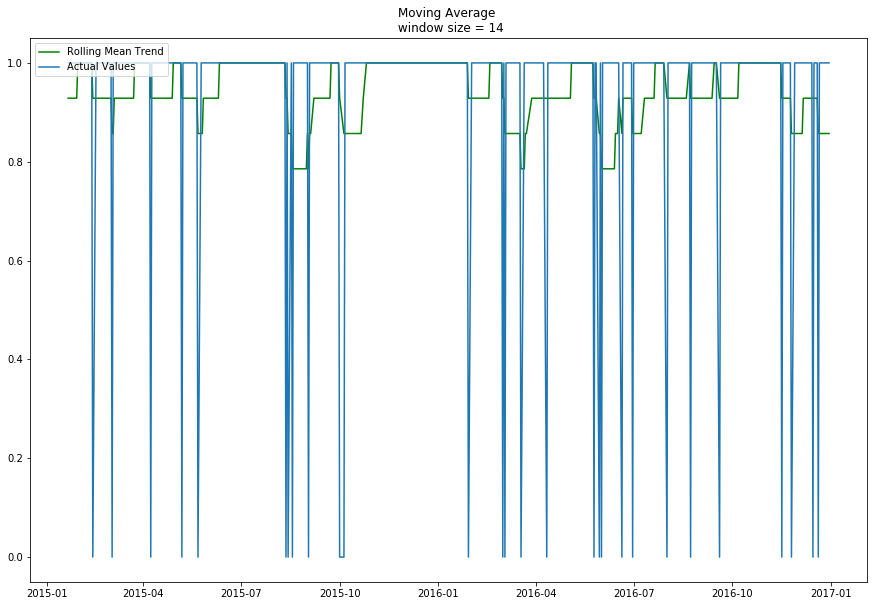

In [104]:
plotMovingAverage(bool_tcs, window = 14)